# Insight Project --Birding Big Year--

In this project I intend to determine a way to see all the birds one can see on a single state, for a given time window.  For all those birdirers that want to get to the top 100 of their state on ebrid, this will be the perfect tool. The user will input the state, home address (or lat,lon), time window and birds that already have been seen*. This last one (*) is an optional thing.

In [1]:
import numpy as np
import geopandas as gpd
import pickle
import googlemaps
import pandas as pd
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import matplotlib
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# import SetCover
import DBScaner
import Definition
# import Itinerary

def save_fig(name):
    fig.savefig(name,dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')

%matplotlib inline

In [2]:
# import importlib
# importlib.reload(Itinerary)

# Here we go 2.0

In [3]:
# geocode_result = gmaps.geocode('{}'.format(userHomeBase))
# pickle.dump(geocode_result, open("./geocode_result_Madison.p", "wb" ))

In [4]:
geocode_result = pickle.load(open("./geocode_result_Madison.p", "rb" ))

In [5]:
state_long = geocode_result[0]['address_components'][2]['long_name']
state_short = geocode_result[0]['address_components'][2]['short_name']

In [6]:
lat = geocode_result[0]['geometry']['location']['lat']
lng = geocode_result[0]['geometry']['location']['lng']

### The ebird Data

The bird data has been trasnform to a Postgres SQL database.  This section of the code reads form this database to do the calculations. 

In [7]:
dbname = Definition.DBNAME
username = Definition.USERNAME
pswd = Definition.PSWD

In [8]:
## Now try the same queries, but in python!

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM test WHERE year = 2018;
"""
dfTrain = pd.read_sql_query(sql_query,con)

### Clustering using BDSCAN

BDSCAN is a density clustering that will tell where is popular for people to go birding (based on the desnity of hotsopts).  I will define a cluster as having atleast 3 point and with a maximum distance of 0.05degrees or about 5km.  With that I will optain where does each hotspot ('LOCALITY') belongs to. If '-1' they are not part of any cluster.

In [18]:
DBScaner.cluster_selection?

In [46]:
dfcluster, labels, n_clusters_ = DBScaner.cluster_selection(dfTrain, eps=0.02, min_samples=2)

In [47]:
n_clusters_

281

In [48]:
dfcluster.head(5)

,locality,latitude,longitude,db_cluster
0,Grantsburg Cemetery,45.776638,-92.676662,0
1,Horicon NWR--Dike Rd.,43.531270,-88.624250,-1
2,Wehr Nature Center,42.925291,-88.035817,1
3,Schumacher Rd. Ponds,43.226397,-89.436549,2
4,UW Madison Arboretum--Spring Trail Pond,43.050024,-89.436577,3


In [49]:
dfCounts = DBScaner.cluster_center(dfcluster, dfTrain)

In [50]:
dfCounts.head(5)

,locality,tot_bird_species,latitude,longitude,db_cluster
0,stakeout Hammond’s Flycatcher (2018),203.0,43.134118,-90.244394,-1
1,Memory Lake Park,150.0,45.779200,-92.686988,0
2,Whitnall Park,171.0,42.931779,-88.033014,1
3,Schumacher Rd. Ponds,109.0,43.226397,-89.436549,2
4,Yahara River--Lake Monona to Upper Mud Lake,194.0,43.045660,-89.329158,3


### Now some good plots

In [51]:
country = gpd.read_file('./gz_2010_us_040_00_5m.json')

In [52]:
unique_labels = set(labels)
colors = [plt.cm.viridis_r(each)
          for each in np.linspace(0, 1, len(unique_labels))]

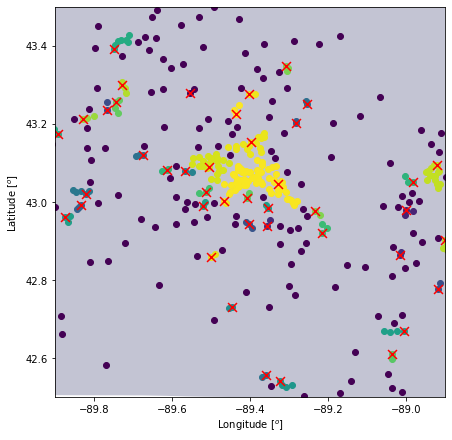

In [56]:
fig, ax = plt.subplots(1, figsize=(7,8))
base = country[country['NAME'].isin([state_long]) == True].plot(ax=ax, color='#3B3C6E', alpha = 0.3)
for i, clust in enumerate(labels):
    ax.scatter(np.array(dfcluster['longitude'])[i],np.array(dfcluster['latitude'])[i], color = colors[clust])
ax.scatter(dfCounts['longitude'],dfCounts['latitude'], marker = 'x', color = 'r', s=80)
ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')
ax.set_xlim([-89.9,-88.9])
ax.set_ylim([42.5,43.5])
save_fig('./{}-test1.png'.format(state_long))
plt.show()

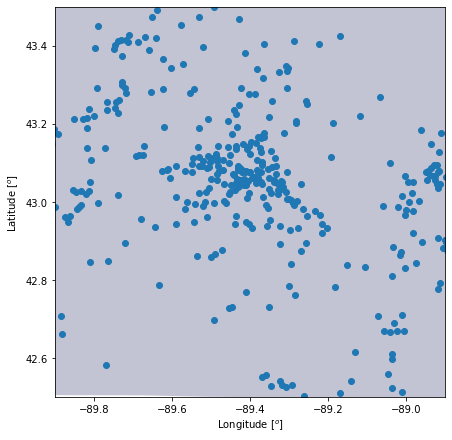

In [57]:
fig, ax = plt.subplots(1, figsize=(7,8))
base = country[country['NAME'].isin([state_long]) == True].plot(ax=ax, color='#3B3C6E', alpha = 0.3)
ax.scatter(dfcluster['longitude'],dfcluster['latitude'])
ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')
ax.set_xlim([-89.9,-88.9])
ax.set_ylim([42.5,43.5])

plt.show()
save_fig('./{}-test2.png'.format(state_long))



### Now the bird probability.

`dfbdscan` have the information of where each of the hotspots lay, in terms of their cluster.  Now in order to constuct a path is important to mask the probabilites of the of seeing a particular bird with T or F on a weekly basis.  This is critical in order to construc the sets.

In [55]:
dfProb = dfTrain.merge(dfcluster.filter(['locality','db_cluster']),
                            left_on='locality', right_on='locality', how = 'left').filter(['common_name','all_species_reported','year_week', 'db_cluster'])

In [ ]:
nTime = 54
nLoc = n_clusters_
setMat = np.empty((nTime,nLoc), dtype=object)

In [ ]:
dfProb[dfProb['common_name'] == 'Mallard']

In [ ]:
for week in range(0,nTime):
    dfProbA = dfProb[dfProb['year_week']== week]
    dfProb1 = dfProbA.groupby(['common_name','db_cluster']).sum().filter(['all_species_reported']).reset_index()
    dfProb1.rename(columns = {'all_species_reported':'pos_obs'}, inplace=True)
    dfProb2 = dfProbA.groupby(['db_cluster']).sum().filter(['all_species_reported']).reset_index()
    dfProb2.rename(columns = {'all_species_reported':'tot_obs'}, inplace=True)
    dfProb3 = dfProb1.merge(dfProb2, left_on='db_cluster', right_on='db_cluster', how = 'left')
    dfProb3['pos_prob'] = dfProb3['pos_obs']/dfProb3['tot_obs']
    for loc in range(0,nLoc):
        dfWeek = dfProb3[dfProb3['db_cluster'] == loc]
        dfWeek['tf'] = list(map(lambda x: 0 if x < 0.02 else 1, dfWeek['pos_prob']))
        setMat[week,loc] = set(dfWeek[dfWeek['tf'] == 1]['common_name'].values)
        

In [ ]:
ToMakeUniverse = list(setMat.flatten())
Universe = set(e for s in ToMakeUniverse for e in s)

In [ ]:
userInput = [lat,lng]

### Calculating google distances (dist matrix)

In [ ]:
gmaps = googlemaps.Client(key='{}'.format(Definition.GOOGLEKEY))

In [ ]:
coorHotspot = np.empty((n_clusters_+1, 2))
coorHotspot[:,0], coorHotspot[:,1] = dfCounts['longitude'],dfCounts['latitude']

In [ ]:
'''
Choose between this and the other seccion.  For test, use the other one, it does not use google dist function.
'''

# distMat = np.empty((nTime,n_clusters_))
# countBreak = divmod(n_clusters_,100)

# for i in range(0,countBreak[0]):
#     distanceMatGmaps = gmaps.distance_matrix(origins = (userInput[0],userInput[1]), 
#                                          destinations=list(coorHotspot[100*i:100*(i+1)]),
#                                          mode = 'driving', units = 'metric')
#     for j in range(100*i,100*(i+1)):
#         jj = j - 100*i
#         try:
#             distMat[:,j] = distanceMatGmaps['rows'][0]['elements'][jj]['duration']['value']/3600
#         except KeyError:
#             distMat[:,j] = 100
        
# distanceMatGmaps = gmaps.distance_matrix(origins = (userInput[0],userInput[1]), 
#                                          destinations=list(coorHotspot[countBreak[0]*100:]),
#                                          mode = 'driving', units = 'metric')

# for j in range(countBreak[0]*100,countBreak[0]*100+countBreak[1]):
#     jj = j - countBreak[0]*100
#     try:
#         distMat[:,j] = distanceMatGmaps['rows'][0]['elements'][jj]['duration']['value']/3600
#     except KeyError:
#         distMat[:,j] = 100

#==========================================================================
#==========================================================================
#==========================================================================

distMat = np.random.rand(nTime*n_clusters_).reshape((nTime,n_clusters_))

In [ ]:
setList, locList = SetCover.set_cover_weighted_greedy(Universe, ToMakeUniverse,list(distMat.flatten()))

In [ ]:
outLoc = Itinerary.location_list_maker(dfCounts,locList, nTime, n_clusters_)

In [ ]:
mapMarkerList = Itinerary.google_map_marker_list(dfCounts, outLoc)

In [ ]:
userOut2 = Itinerary.dic_user_ouput_maker(dfCounts,locList,nTime, nLoc)